# 

In [1]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
from calibration import generate_truth_locations, recover_homographies, recover_intrinsics

In [2]:
# 相机
class Camera:
    def __init__(self) -> None:
        pass

    @staticmethod
    def static_calibrate(gray_images: np.ndarray, chessboard_size: tuple, chessboard_cell_size: tuple, save_image:bool=False, save_dir:str='./images/') -> np.ndarray:
        # H矩阵
        H_s = []
        for i in range(gray_images.shape[0]):
            # 寻找棋盘格角点的模式 自适应阈值+标准化图片
            chessboard_flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE

            ret, corners = cv2.findChessboardCorners(
                gray_images[i], chessboard_size, chessboard_flags)
            # 若未找到角点则退出
            if ret is not True:
                continue

            # 进一步优化角点坐标
            criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                        cv2.TERM_CRITERIA_EPS, 30, 0.001)
            corners = cv2.cornerSubPix(
                gray_images[i], corners, (11, 11), (-1, -1), criteria)
            # 保存棋盘格角点图片
            if save_image:
                img = cv2.drawChessboardCorners(copy.deepcopy(
                    gray_images[i]), chessboard_size, corners, ret,)
                for j in range(3):
                    cv2.circle(img, (int(corners[j][0][0]), int(
                        corners[j][0][1])), 60, (0, 0, 255), 0)
                cv2.imwrite(save_dir+'corners_{}.jpg'.format(i), img=img)

            # 生成角点在世界坐标系下的坐标点
            truth_locations = generate_truth_locations(
                chessboard_size, chessboard_cell_size)

            # 计算H矩阵
            corners = corners.reshape(-1, 2)
            H = recover_homographies(corners, truth_locations)
            H /= H[-1, -1]
            H_s.append(H)
        H_s = np.array(H_s)
        K = recover_intrinsics(H_s)
        return K


In [3]:
cap = cv2.VideoCapture("./images/c.mp4")
frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
h_ = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w_ = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
gray_video = np.zeros((frame_num, h_, w_),dtype=np.uint8)
int(cap.get(7))
count = 0
for i in range(frame_num):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_video[count] = gray
    count += 1


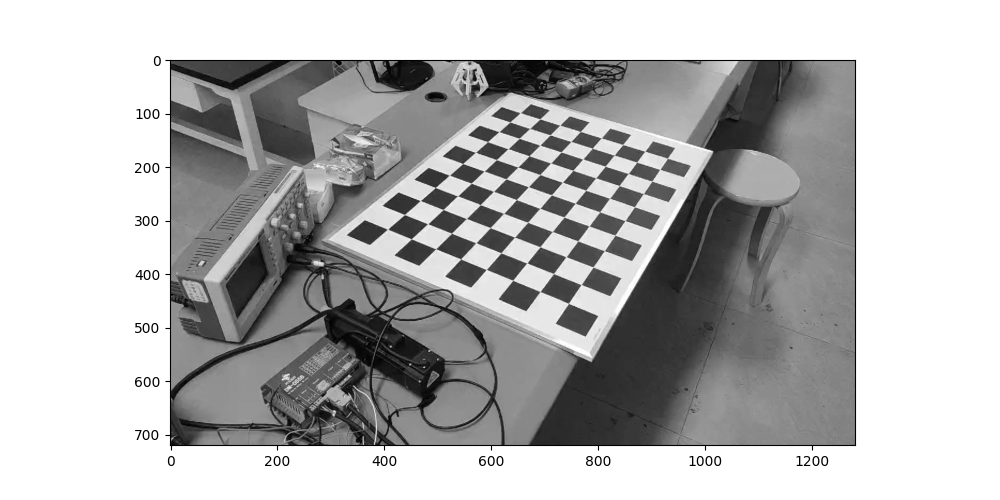

In [5]:
%matplotlib widget
plt.figure(figsize=(10,5))
plt.imshow(gray_video[0],'gray')
plt.show()

In [ ]:
K = Camera.static_calibrate(gray_video, chessboard_size=(
    11, 8), chessboard_cell_size=(60, 60),save_image=False)

<p>
<img style="float: left;" src="images/corners_100.jpg" width=800 />
</p>

In [6]:
print("相机内参矩阵为：\n{}".format(K))

相机内参矩阵为：
[[ 1.20981082e+03 -6.38606499e-01  6.27897309e+02]
 [ 0.00000000e+00  1.18458039e+03  3.30943028e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [7]:
# 计算图像特征点计算类
class OrbFeatureDetector:
    orb = cv2.ORB_create()

    def __init__(self):
        pass

    def cross_detect(self, gray1: np.ndarray, gray2: np.ndarray):
        kp1, des1 = self.orb.detectAndCompute(gray1, None)
        kp2, des2 = self.orb.detectAndCompute(gray2, None)
        # crossCheck=True，两张图的点A→B和B→A各算一次。
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(des1, des2, k=2)

        good_matches = [[x1]
                        for x1, x2 in matches if x1.distance < 0.75*x2.distance]
        if len(good_matches) <= 8:
            return None, None, None
        return kp1, kp2, good_matches


In [8]:
# slam 视频
cap = cv2.VideoCapture("./images/1.mp4")
frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
h_ = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w_ = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
gray_video = np.zeros((frame_num, h_, w_),dtype=np.uint8)
int(cap.get(7))
count = 0
for i in range(frame_num):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_video[count] = gray
    count += 1


In [9]:
gray1 = gray_video[0]

In [10]:
gray2 = gray_video[50]

In [11]:
orbDetector = OrbFeatureDetector()

In [12]:
kp1, kp2, good_matches = orbDetector.cross_detect(gray1, gray2)


In [13]:
result = cv2.drawMatchesKnn(gray1, kp1, gray2, kp2, good_matches, None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchColor=(0, 255, 0))


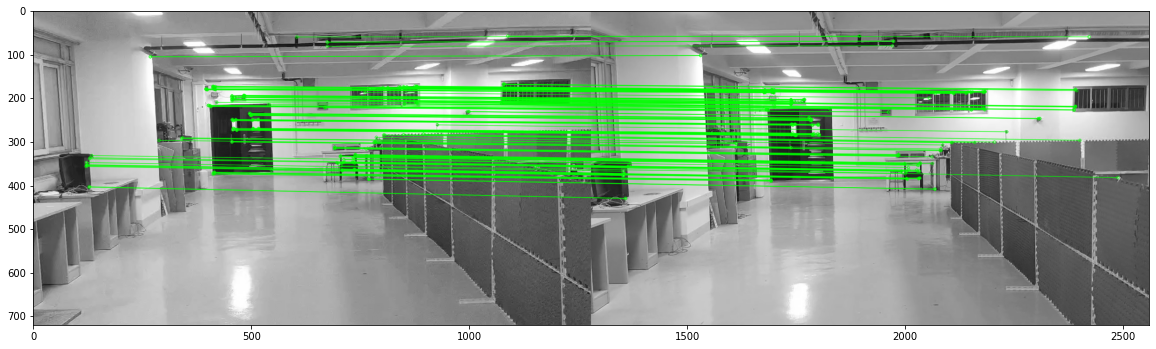

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

In [15]:
matched_pixel_coor_pairs = list()
for match in good_matches:
    # trainIdx 上一帧关键点的索引
    # queryIdx 当前帧关键点的索引
    pre_pixel_coor = (int(kp1[match[0].queryIdx].pt[0]),
                      int(kp1[match[0].queryIdx].pt[1]))
    cur_pixel_coor = (int(kp2[match[0].trainIdx].pt[0]),
                      int(kp2[match[0].trainIdx].pt[1]))
    matched_pixel_coor_pairs.append((pre_pixel_coor, cur_pixel_coor))
    # print(matched_pixel_location_pairs)
    # break
len(matched_pixel_coor_pairs)

197

In [16]:

# %matplotlib widget
frame3 = copy.deepcopy(gray2)
for pixel_coor_pair in matched_pixel_coor_pairs:
    cv2.circle(frame3, pixel_coor_pair[1], color=(0,0,255), radius=3)
    cv2.line(frame3, pixel_coor_pair[0], pixel_coor_pair[1], color=(255,0,0))


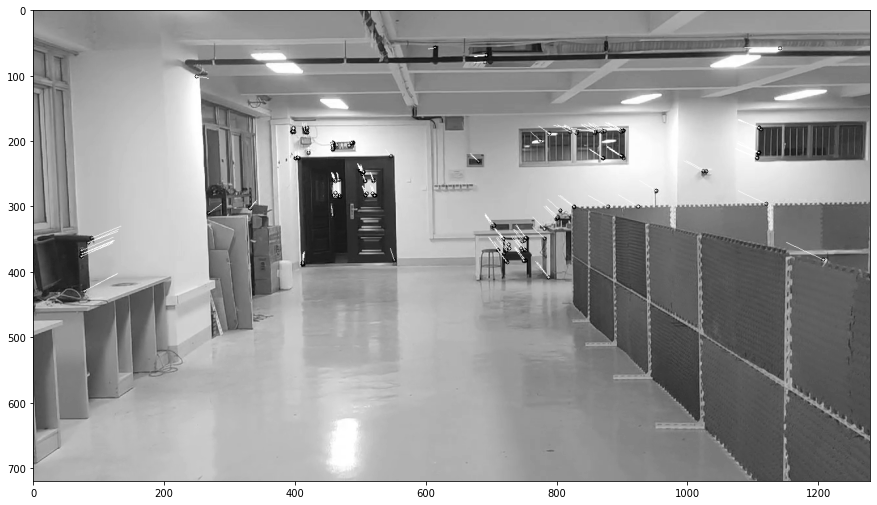

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(15, 10))
axes = fig.subplots(1, sharey=True)
axes.imshow(frame3,cmap="gray")
plt.show()

# 三角测量

<p>
<img width=800 src="./images/三角测量.png">
</p>

已知：

$$
\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = \frac{1}{^cZ}K{}^cT_w{}^wP = \frac{1}{^cZ}
\begin{bmatrix}
    k_x & 0 & u_b & 0 \\
    0 & k_y & v_b & 0\\
    0 & 0 & 1 & 0\\
\end{bmatrix}
\begin{bmatrix}
    R & p \\
    0 & 1 \\
\end{bmatrix}_{4\times4}
\begin{bmatrix}
    ^wX \\
    ^wY \\
    ^wZ \\
    1
\end{bmatrix}
$$

则有：

$$
K^{-1}{}\begin{bmatrix}
    u \\ v \\ 1
\end{bmatrix} = {}^cT_w{}^wP =
\begin{bmatrix}
    R & p \\
    0 & 1 \\
\end{bmatrix}_{4\times4}\frac{1}{{}^cZ}
\begin{bmatrix}
    ^wX \\
    ^wY \\
    ^wZ \\
    1
\end{bmatrix}
$$

上式左边为一个三维向量，设为$^cp$，则有:

$$0={}^cp^{\land}{}^cp={}^cp^{\land}{}^cT_w{}^w\frac{1}{^cZ}P$$

令$A={}^cp^{\land}{}^cT_w{}^w$，则求解$P$与${}^cZ$变成了一个简单的线性方程组求解问题。因为${}^cp^{\land}{}^cT_w$秩为$2$，每个被匹配到的特征点都可以为线性方程组提供两个约束。同时，若不考虑常数比例为线性方程组带来影响，同时将${}^cp$转变为标准齐次坐标，则最后计算出来的结果为$\frac{1}{^cZ}P$只需要对最后一个值归一化即可计算出点的实际坐标，可以简化计算过程。

In [18]:
from skimage.measure import ransac
from skimage.transform import EssentialMatrixTransform


class EG:
    W = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    """
    Epipolar Geometry
    """
    @staticmethod
    def normalize(K: np.ndarray, p: np.ndarray) -> np.ndarray:
        normalized_p = np.ones((len(p), 3))
        normalized_p[:, :2] = p
        normalized_p = (np.linalg.inv(K) @ normalized_p.T).T
        normalized_p = normalized_p[:, :2]
        return normalized_p

    @staticmethod
    def resolve_essential_matrix(K: np.ndarray, p1s, p2s) -> np.ndarray:
        normal_p1s = EG.normalize(K, p1s)
        normal_p2s = EG.normalize(K, p2s)
        # 求解本质矩阵和内点数据
        E, inliers = ransac((normal_p1s, normal_p2s),
                            EssentialMatrixTransform,
                            min_samples=8,              # 最少需要 8 个点
                            residual_threshold=0.005,
                            max_trials=200)
        return E, inliers

    @staticmethod
    def decompose_E(E: np.ndarray):
        U, S, Vh = np.linalg.svd(E)
        R1 = U @ EG.W @ Vh
        R2 = U @ EG.W.T @ Vh
        idx = np.argmin(S)
        t = U.T[idx]
        return R1, R2, t

    @staticmethod
    def check_RT(K, R_s, t, matches):
        best_R = None
        best_t = None
        pose1 = np.eye(3, 4)
        pose2 = np.zeros((3, 4))
        p3ds1 = []
        for R in R_s:
            pose2[:, :3] = R
            pose2[:, 3] = t
            p3ds1.append(EG.triangulate(K, pose1, pose2, matches))
            pose2[:, 3] = -t
            p3ds1.append(EG.triangulate(K, pose1, pose2, matches))
        return p3ds1

    @staticmethod
    def triangulate(K, pose1, pose2, matches):
        pts1 = EG.normalize(K, matches[:, 0])                 # 使用相机内参对角点坐标归一化
        pts2 = EG.normalize(K, matches[:, 1])

        points4d = np.zeros((pts1.shape[0], 4))

        for i, (kp1, kp2) in enumerate(zip(pts1, pts2)):
            A = np.zeros((4, 4))
            A[0] = kp1[0] * pose1[2] - pose1[0]
            A[1] = kp1[1] * pose1[2] - pose1[1]
            A[2] = kp2[0] * pose2[2] - pose2[0]
            A[3] = kp2[1] * pose2[2] - pose2[1]
            _, _, vt = np.linalg.svd(A)         # 对 A 进行奇异值分解
            points4d[i] = vt[-1]
        points4d /= points4d[:, 3:]            # 归一化变换成齐次坐标 [x, y, z, 1]
        # points3d = points4d[:, :3]
        return points4d



In [19]:
frame1 = gray_video[0]
frame2 = gray_video[50]

In [20]:
kp1, kp2, good_matches = orbDetector.cross_detect(
    frame1, frame2)
curr_pose = np.eye(4)
# 获取关键点坐标数据
matched_pixel_coor_pairs = list()
for match in good_matches:
    # trainIdx 上一帧关键点的索引
    # queryIdx 当前帧关键点的索引
    pre_pixel_coor = (int(kp1[match[0].queryIdx].pt[0]),
                      int(kp1[match[0].queryIdx].pt[1]))
    cur_pixel_coor = (int(kp2[match[0].trainIdx].pt[0]),
                      int(kp2[match[0].trainIdx].pt[1]))
    matched_pixel_coor_pairs.append((pre_pixel_coor, cur_pixel_coor))
matched_pixel_coor_pairs = np.array(matched_pixel_coor_pairs)
# 求解本质矩阵E，同时获取内点索引
E, inliers = EG.resolve_essential_matrix(
    K, matched_pixel_coor_pairs[:, 0], matched_pixel_coor_pairs[:, 1])
R1, R2, t = EG.decompose_E(E.params)
r = EG.check_RT(K,[R1, R2], t, matched_pixel_coor_pairs)


In [21]:
K

array([[ 1.20981082e+03, -6.38606499e-01,  6.27897309e+02],
       [ 0.00000000e+00,  1.18458039e+03,  3.30943028e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [22]:
E.params

array([[-0.04239006, -5.42313134, -0.98159233],
       [ 5.42664938, -0.25319051, -4.45355874],
       [ 1.00994762,  4.7658621 ,  0.07285397]])

In [23]:
r[1]

array([[-2.51793984e+00, -3.65419891e-01,  1.78680301e+01,
         1.00000000e+00],
       [ 7.73995126e-01, -4.33939195e+00,  1.99797991e+01,
         1.00000000e+00],
       [-1.83672393e+00, -1.12338473e+00,  1.79250559e+01,
         1.00000000e+00],
       [ 1.23293358e+00,  1.10940688e-01,  1.89511823e+01,
         1.00000000e+00],
       [ 8.71486697e+00, -9.82633134e-01,  2.33331041e+01,
         1.00000000e+00],
       [-3.19563610e+00, -2.28430759e+00,  1.79396645e+01,
         1.00000000e+00],
       [-4.59407455e+00,  3.29101094e-01,  1.10060971e+01,
         1.00000000e+00],
       [-3.25816791e+00, -1.58329430e+00,  1.75079728e+01,
         1.00000000e+00],
       [ 1.29438252e+00,  6.29470388e-01,  1.88276884e+01,
         1.00000000e+00],
       [ 1.75478047e+00,  3.74735623e-01,  1.91295547e+01,
         1.00000000e+00],
       [ 3.68901282e+00, -2.29232128e+00,  1.76692791e+01,
         1.00000000e+00],
       [-1.88885782e+00, -1.28911735e+00,  1.78609169e+01,
      

In [24]:
class MVM:
    """
    Monocular vision mileage
    """
    feature_detector = OrbFeatureDetector()

    eg_operator = EG()

    def __init__(self, camera_K: np.ndarray) -> None:
        # 单目相机内参
        self.camera_K = camera_K
        # 单张图片基础矩阵
        self.camera_H = None

        # 用于特征检测的帧
        self.frame1 = None
        self.frame2 = None

        # 环境关键点
        self.ENV_keypoints = list()
        # 相机轨迹
        self.camera_trajectory = list()

    def get_key_frame(self, gray: np.ndarray) -> bool:
        """
        获取关键帧
        """
        if self.frame1 is None:
            # 初始化第一帧
            self.frame1 = gray
            return False
        if self.frame2 is None:
            # 初始化第二帧
            self.frame2 = gray
            return True
        self.frame1 = self.frame2
        self.frame2 = gray
        return True

    def test():
        pass

    def __trajectory_reconstruction(self) -> None:
        # 关键点匹配
        kp1, kp2, good_matches = self.feature_detector.cross_detect(
            self.frame1, self.frame2)
        # 获取关键点坐标数据
        matched_pixel_coor_pairs = list()
        for match in good_matches:
            # trainIdx 上一帧关键点的索引
            # queryIdx 当前帧关键点的索引
            pre_pixel_coor = (int(kp1[match[0].queryIdx].pt[0]),
                              int(kp1[match[0].queryIdx].pt[1]))
            cur_pixel_coor = (int(kp2[match[0].trainIdx].pt[0]),
                              int(kp2[match[0].trainIdx].pt[1]))
            matched_pixel_coor_pairs.append((pre_pixel_coor, cur_pixel_coor))
        matched_pixel_coor_pairs = np.array(matched_pixel_coor_pairs)
        # 求解本质矩阵E，同时获取内点索引
        E, inliers = EG.resolve_essential_matrix(
            self.camera_K, matched_pixel_coor_pairs[:, 0], matched_pixel_coor_pairs[:, 1])
        
        #

    def process(self, gray: np.ndarray) -> None:
        if not self.get_key_frame(gray):
            return

        self.__trajectory_reconstruction()


In [25]:
K

array([[ 1.20981082e+03, -6.38606499e-01,  6.27897309e+02],
       [ 0.00000000e+00,  1.18458039e+03,  3.30943028e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [26]:
np.linalg.inv(K)

array([[ 8.26575511e-04,  4.45606306e-07, -5.19152009e-01],
       [ 0.00000000e+00,  8.44180781e-04, -2.79375743e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [27]:
c_p = np.ones((3))

In [28]:
c_p

array([1., 1., 1.])

In [29]:
np.linalg.inv(K) @ c_p

array([-0.51832499, -0.27853156,  1.        ])